In [6]:
using DifferentialEquations

## Define the ThreeBody Problem
const threebody_μ = parse(Float64,"0.012277471"); const threebody_μ′ = 1 - threebody_μ

f = (t,u,du) -> begin
  # 1 = y₁
  # 2 = y₂
  # 3 = y₁'
  # 4 = y₂'
  D₁ = ((u[1]+threebody_μ)^2 + u[2]^2)^(3/2)
  D₂ = ((u[1]-threebody_μ′)^2 + u[2]^2)^(3/2)
  du[1] = u[3]
  du[2] = u[4]
  du[3] = u[1] + 2u[4] - threebody_μ′*(u[1]+threebody_μ)/D₁ - threebody_μ*(u[1]-threebody_μ′)/D₂
  du[4] = u[2] - 2u[3] - threebody_μ′*u[2]/D₁ - threebody_μ*u[2]/D₂
end

prob = ODEProblem(f,[0.994, 0.0, 0.0, parse(Float64,"-2.00158510637908252240537862224")])

t₀ = 0.0; T = parse(Float64,"17.0652165601579625588917206249")

tspan = [t₀,T]
tspan2 = [t₀,2T]
abstols = 1./10.^(3:13)
reltols = 1./10.^(0:10);

This three-body problem is known to be a tough problem. Let's see how the algorithms fair at standard tolerances.

### 5th Order Runge-Kutta Methods

First, here's the results of the algorithms from the other packages.

#### ODE.jl



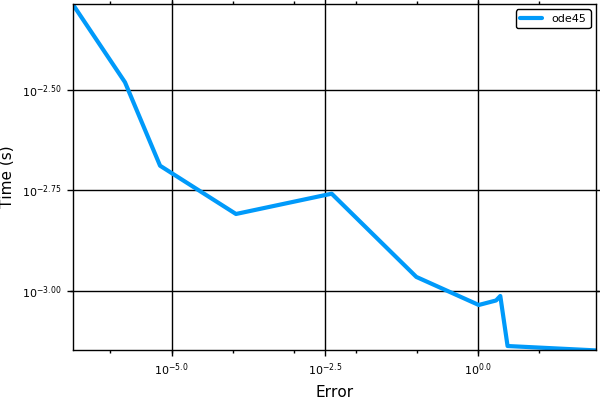

In [13]:
setups = [Dict(:alg=>:ode45)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,dense=false,save_timeseries=false)

ODE.jl fails on this test. This is likely due to its lack of stabilization. It stops early and so its error estimate is not reliable.

#### ODEInterface.jl



In [14]:
setups = [Dict(:alg=>:dopri5)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,dense=false,save_timeseries=false)

WorkPrecisionSet of 1 wps


Same with ODEInterface. Note that both this and ODE.jl are run using their own algorithm defaults and failing.

#### DifferentialEquations.jl


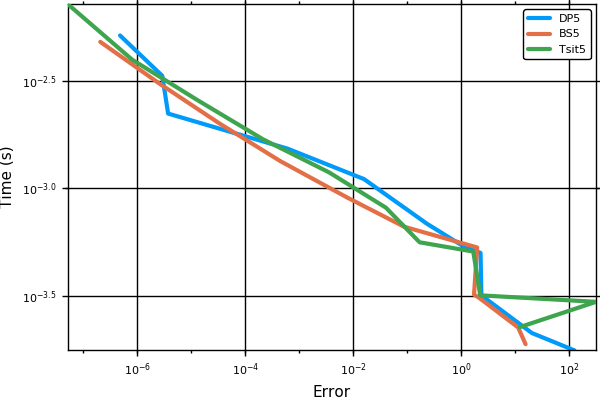

In [16]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,dense=false,save_timeseries=false,numruns=100)
plot(wp)

#### Full save, but no dense


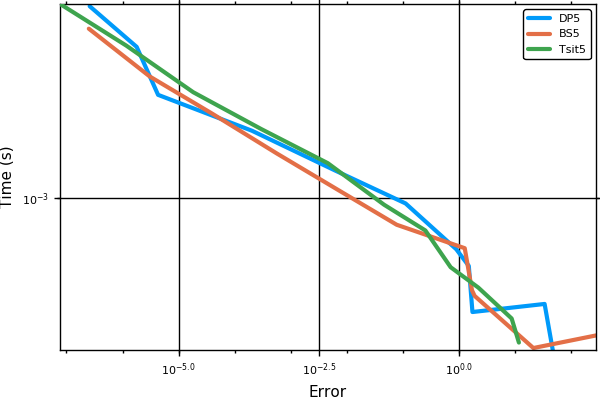

In [17]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,β=0.04,expo1=.17,qmin=0.2,qmax=10.0,fullnormalize=false,dense=false,numruns=100)
plot(wp)

#### Dense


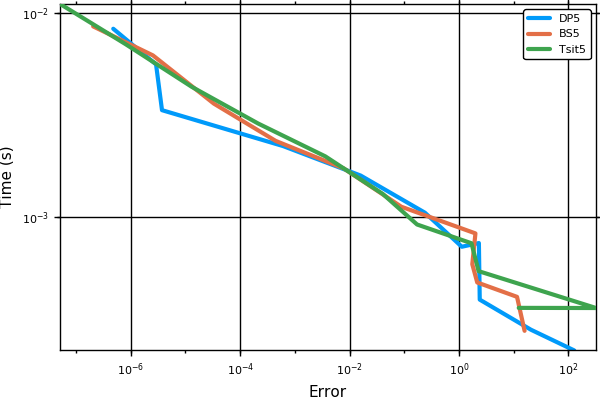

In [18]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:BS5)
          Dict(:alg=>:Tsit5)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,numruns=100)
plot(wp)

In these tests we see that most of the algorithms are close,with `BS5` and `DP5` showing much better than `Tsit5`. `ode45` errors.

### Higher Order Algorithms


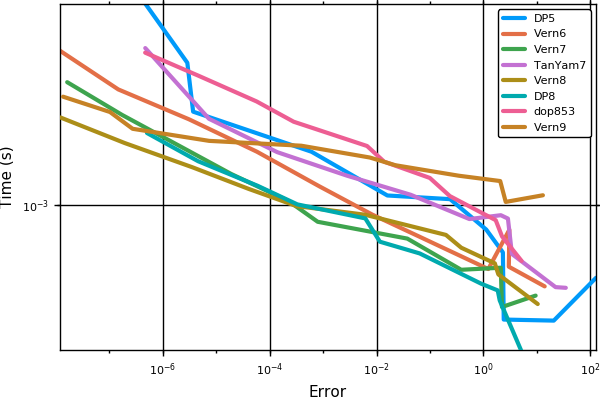

In [19]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern6)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern9)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,dense=false,save_timeseries=false,numruns=100)
plot(wp,lw=3)


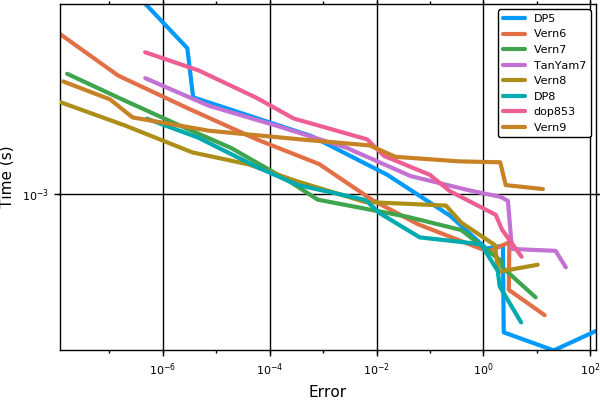

In [20]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern6)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern9)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,dense=false,numruns=100)
plot(wp,lw=3)


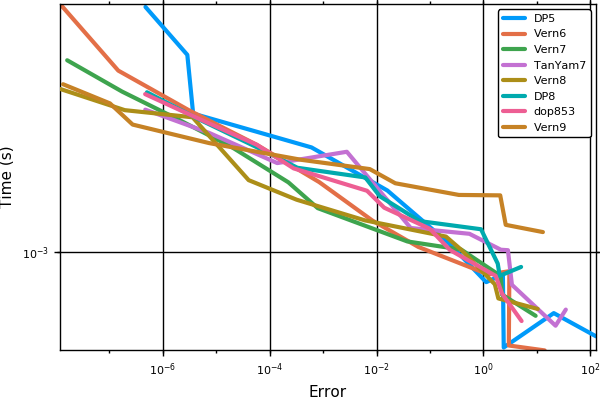

In [21]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern6)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:dop853)
          Dict(:alg=>:Vern9)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,numruns=100)
plot(wp,lw=3)

In this test we see `:Vern6` and `:Vern7` shine.

### Other Algorithms

Once again we separate ODE.jl because it fails:


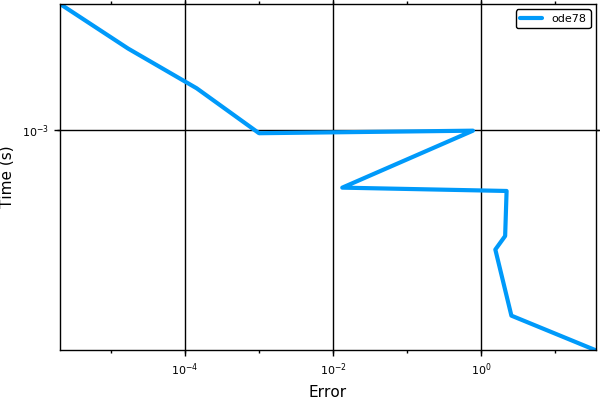

In [23]:
setups = [Dict(:alg=>:ode78)];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,dense=false,numruns=100)
plot(wp,lw=3)

[DifferentialEquations.jl] Initializing backend: Sundials



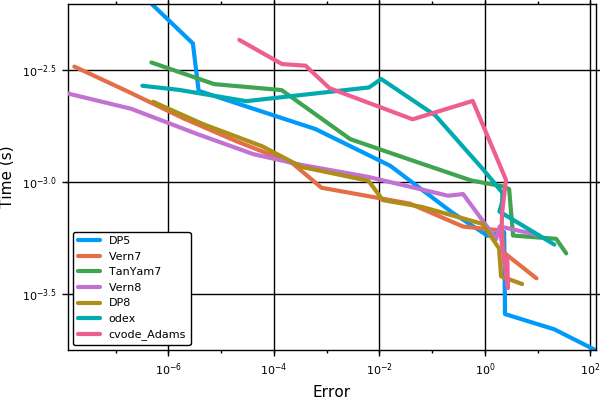

In [22]:
setups = [Dict(:alg=>:DP5)
          Dict(:alg=>:Vern7)
          Dict(:alg=>:TanYam7)
          Dict(:alg=>:Vern8)
          Dict(:alg=>:DP8)
          Dict(:alg=>:odex)
          Dict(:alg=>:cvode_Adams)
    ];
wp = ode_workprecision_set(prob,tspan,abstols,reltols,setups;endsol=prob.u₀,dense=false,numruns=100)
plot(wp,lw=3)

### Conclusion

As in the other tests, the DifferentialEquations.jl algorithms with the Verner Efficient methods are the most efficient solvers at stringent tolerances, while the order 5 methods do well at cruder tolerances.